In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, FloatSlider, IntSlider
from scipy.signal import chirp

In [2]:
## Parameters
C = 3 * 10**8    # Speed of light

L = 100          # Length of target strip
B = 100          # Width of target strip

v = 100          # Velocity of the sensor (m/s)
beta = 40        # Grazing Angle (degrees)
omega = 20       # Integration Angle (degrees)
h = 10000        # Height of sensor from ground (m)
max_h = 0        # Maximum height capturable by sensor (m)
PRI = 1/2000     # Pulse Repetition Interval (Hz)

x_t = 0         # Target x-coordinate
y_t = 0         # Target y-coordinate
z_t = 50         # Target z-coordinate

In [3]:
# Derived parameters
omega = math.radians(omega)
beta = math.radians(beta)

y_c = h / math.tan(beta)   # Horizontal distance to the origin of target strip
d_c = h / math.sin(beta)   # Slant distance to the origin of target strip

delta_min = - y_c * math.tan(0.5 * omega)       # Maximum negative distance deviation from APC 
delta_max = y_c * math.tan(0.5 * omega)         # Maximum positive distance deviation from APC

num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

In [4]:
# Function to calculate distance deviation of current sensor based on sample index
cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

# Function to calculate slant distance of the target from the current sensor position
cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   

# Assume that the distance deviation of sensor when it emit and receive signal is neglible
cal_time_pulse = lambda distance : 2 * (distance / C)
cal_distance_from_time = lambda pulse_time : pulse_time * C * 0.5 

# Get near and far range time (to gate)
near_range_time = cal_time_pulse(
        math.sqrt((max(0, h - max_h))**2 + (y_c - B/2.0)**2)
    )
far_range_time = cal_time_pulse(
        math.sqrt((math.sqrt((delta_max + L/2.0)**2 + (y_c + B/2.0)**2))**2 + h**2)
    )

In [5]:
time_result = []

for i in range(math.floor(num_of_samples)):
    dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
    target_slant_distance = cal_target_slant_distance(dist_deviation)   
    time_pulse = cal_time_pulse(target_slant_distance)
    time_result.append(time_pulse)

time_result = np.array(time_result)

# Halved to get the distance to the target
distance_result = cal_distance_from_time(time_result)    

print( f"near range time: {near_range_time}")
print( f"far range time: {far_range_time}")
print( f"number of samples {math.floor(num_of_samples)}")
print( f"resulting pulse time: {time_result}")

near range time: 0.00010345979550928658
far range time: 0.0001049550942068235
number of samples 84055
resulting pulse time: [0.00010444 0.00010444 0.00010444 ... 0.00010444 0.00010444 0.00010444]


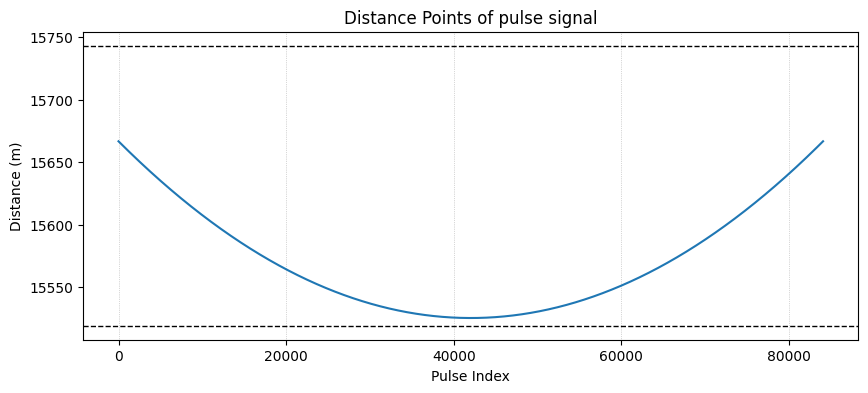

In [6]:
# Plot of pulse time
plt.figure(figsize=(10, 4))


plt.plot(distance_result) # Plot of distance to pulse index
plt.ylabel("Distance (m)")
plt.xlabel("Pulse Index")
plt.axhline(cal_distance_from_time(near_range_time), color='black', linestyle='--', linewidth=1)
plt.axhline(cal_distance_from_time(far_range_time), color='black', linestyle='--', linewidth=1)
plt.title("Distance Points of pulse signal")
plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
plt.show()

## Simulate Pulse
This is an interactive simulation of the distance a signal travels if a sensor is assumed to be moving horizontally in the azimuth

In [7]:
def simulate_time_result(light_speed: float = 3e8, 
                         azimuth_length: float = 100.0, 
                         range_width: float = 100.0, 
                         sensor_speed: float = 100.0, 
                         grazing_angle_deg: float = 40.0,
                         integration_angle_deg: float = 20.0,
                         sensor_height: float = 10000.0,
                         max_capturable_height: float = 0,
                         sampling_frequency: float = 2000,
                         target_x: float = 0,
                         target_y: float = 0,
                         target_z: float = 50):

    # Derived parameters
    integration_angle_rad = math.radians(integration_angle_deg)
    grazing_angle_rad = math.radians(grazing_angle_deg)

    h = sensor_height
    v = sensor_speed
    L = azimuth_length
    B = range_width
    C = light_speed
    max_h = max_capturable_height
    x_t, y_t, z_t = target_x, target_y, target_z
    PRI = 1 / sampling_frequency

    y_c = h / math.tan(grazing_angle_rad)   # Horizontal distance to the origin of target strip
    d_c = h / math.sin(grazing_angle_rad)   # Slant distance to the origin of target strip

    delta_min = - y_c * math.tan(0.5 * integration_angle_rad)       # Maximum negative distance deviation from APC 
    delta_max = y_c * math.tan(0.5 * integration_angle_rad)         # Maximum positive distance deviation from APC

    num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

    # Function to calculate distance deviation of current sensor based on sample index
    cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

    # Function to calculate slant distance of the target from the current sensor position
    cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   

    # Assume that the distance deviation of sensor when it emit and receive signal is neglible
    cal_time_pulse = lambda distance : 2 * (distance / C)
    cal_distance_from_time = lambda pulse_time : pulse_time * C * 0.5 

    # Get near and far range time (to gate)
    near_range_time = cal_time_pulse(
            math.sqrt((max(0, h - max_h))**2 + (y_c - B/2.0)**2)
        )
    far_range_time = cal_time_pulse(
            math.sqrt((math.sqrt((delta_max + L/2.0)**2 + (y_c + B/2.0)**2))**2 + h**2)
        )   

    time_result = []

    for i in range(math.floor(num_of_samples)):
        dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
        target_slant_distance = cal_target_slant_distance(dist_deviation)   
        time_pulse = cal_time_pulse(target_slant_distance)
        time_result.append(time_pulse)

    time_result = np.array(time_result)

    # Halved to get the distance to the target
    distance_result = cal_distance_from_time(time_result)   

    # Get Chirp
    # emitted_chirps, received_chirps = simulate_chirp_signal(num_of_samples, time_result, PRI)
    # plot_chirp_signal(emitted_chirps, received_chirps)

    plot_distance_pulse(distance_result, near_range_time, far_range_time)


def plot_distance_pulse(distance_result, near_range_time, far_range_time):
    # Plot of pulse time
    plt.figure(figsize=(10, 4))

    plt.plot(distance_result) # Plot of distance to pulse index
    plt.ylabel("Distance (m)")
    plt.xlabel("Pulse Index")
    plt.axhline(cal_distance_from_time(near_range_time), color='black', linestyle='--', linewidth=1)
    plt.axhline(cal_distance_from_time(far_range_time), color='black', linestyle='--', linewidth=1)
    plt.title("Distance Points of pulse signal")
    plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
    plt.show()


def generate_chirp(start_time=0,
                   amplitude=1.0,
                   frequency=1.0,
                   pulse_width=1.0,
                   bandwidth=1.0,
                   sampling_frequency=10000):
    num_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(start_time, start_time + pulse_width, num_samples, endpoint=False)
    gamma = bandwidth / pulse_width
    quadratic_phase = np.pi * gamma * (t - (start_time + pulse_width / 2))**2
    y = amplitude * np.sin(2 * np.pi * frequency * t + quadratic_phase)
    return t, y


def simulate_chirp_signal(num_of_samples, time_result, PRI):
    emitted_chirps = []
    received_chirps = []

    for i in range(math.floor(num_of_samples)):
        current_time = i * PRI     # Each multiple of PRI indicates a new emitted chirp signal
        
        # Simulate emitted signal
        t_emit, tx_signal_emit = generate_chirp(current_time,
                                        amplitude=1.0,
                                        frequency=5,
                                        pulse_width=6.0,
                                        bandwidth=10.0,
                                        sampling_frequency=1000)

        # Simulate received signal
        t_recv, tx_signal_recv = generate_chirp(current_time+time_result[i],
                                        amplitude=1.0,
                                        frequency=5,
                                        pulse_width=6.0,
                                        bandwidth=10.0,
                                        sampling_frequency=1000)

        emitted_chirps.append((t_emit, tx_signal_emit))
        received_chirps.append((t_recv, tx_signal_recv))

    return emitted_chirps, received_chirps


In [ ]:
sliders = {
    "azimuth_length": FloatSlider(min=10.0, max=1000.0, step=0.1, value=100.0),
    "range_width": FloatSlider(min=10.0, max=1000.0, step=0.1, value=100.0),
    "sensor_speed": FloatSlider(min=10.0, max=500, step=0.1, value=100.0),
    "grazing_angle_deg": FloatSlider(min=0.1, max=90, step=0.1, value=40.0),
    "integration_angle_deg": FloatSlider(min=0, max=180, step=0.1, value=20.0),
    "sensor_height": FloatSlider(min=100, max=1000000, step=0.1, value=10000.0),
    "max_capturable_height": FloatSlider(min=0, max=1000, step=0.1, value=0),
    "sampling_frequency": IntSlider(min=1, max=5000, step=1, value=2000)
}
sliders["target_x"] = FloatSlider(min=-sliders["azimuth_length"].value/2, 
                                  max=sliders["azimuth_length"].value/2, 
                                  step=0.1, 
                                  value=0.0)
sliders["target_y"] = FloatSlider(min=-sliders["range_width"].value/2, 
                                  max=sliders["range_width"].value/2, 
                                  step=0.1, 
                                  value=0.0)
sliders["target_z"] = FloatSlider(min=0, 
                                  max=sliders["max_capturable_height"].value, 
                                  step=0.1, 
                                  value=0.0)

def update_target_x_slider_range(change):
    sliders["target_x"].min = change['new']/2
    sliders["target_x"].max = change['new']/2
    if sliders["target_x"].value > sliders["target_x"].max:
        sliders["target_x"].value = sliders["target_x"].max
    if sliders["target_x"].value < sliders["target_x"].min:
        sliders["target_x"].value = sliders["target_x"].min

def update_target_y_slider_range(change):
    sliders["target_y"].min = change['new']/2
    sliders["target_y"].max = change['new']/2
    if sliders["target_y"].value > sliders["target_y"].max:
        sliders["target_y"].value = sliders["target_y"].max
    if sliders["target_y"].value < sliders["target_y"].min:
        sliders["target_y"].value = sliders["target_y"].min

def update_target_z_slider_range(change):
    sliders["target_z"].max = change['new']
    if sliders["target_z"].value > sliders["target_z"].max:
        sliders["target_z"].value = sliders["target_z"].max

sliders["azimuth_length"].observe(update_target_x_slider_range, names="value")
sliders["range_width"].observe(update_target_y_slider_range, names="value")
sliders["max_capturable_height"].observe(update_target_z_slider_range, names="value")


def plot_distance_interactive(
                         azimuth_length,
                         range_width,
                         sensor_speed,
                         grazing_angle_deg,
                         integration_angle_deg,
                         sensor_height,
                         max_capturable_height,
                         sampling_frequency,
                         target_x,
                         target_y,
                         target_z):
    simulate_time_result(3e8, azimuth_length, range_width,
                         sensor_speed, grazing_angle_deg, integration_angle_deg,
                         sensor_height, max_capturable_height, sampling_frequency,
                         target_x, target_y, target_z)


ui = interactive(plot_distance_interactive, **sliders)
display(ui)

interactive(children=(FloatSlider(value=100.0, description='azimuth_length', max=1000.0, min=10.0), FloatSlide…

## Simulation of the pulse in time domain for a target

In [9]:
def plot_chirp_sinusoid(amplitude=1.0, 
                        frequency=1.0, 
                        pulse_width=1.0, # The total time of a pulse
                        bandwidth=1.0,
                        sampling_frequency=10000, 
                        axis_limit=2):
    
    # Plot time axis starts from 0 as per time domain
    t = np.linspace(0, axis_limit * np.pi, sampling_frequency)

    gamma = bandwidth/pulse_width     # A constant 
    quadratic_phase = np.pi * gamma * (t - pulse_width/2)**2 # quadratic phase shift required for chirp

    y = amplitude * np.sin( 2 * np.pi * frequency * t + quadratic_phase)

    # Plot of chirp wave
    plt.figure(figsize=(10, 4))
    plt.plot(t, y, label=f'{amplitude} sin(2* pi * {frequency}t + {quadratic_phase[0]})')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.title('Sinusoidal Wave')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()



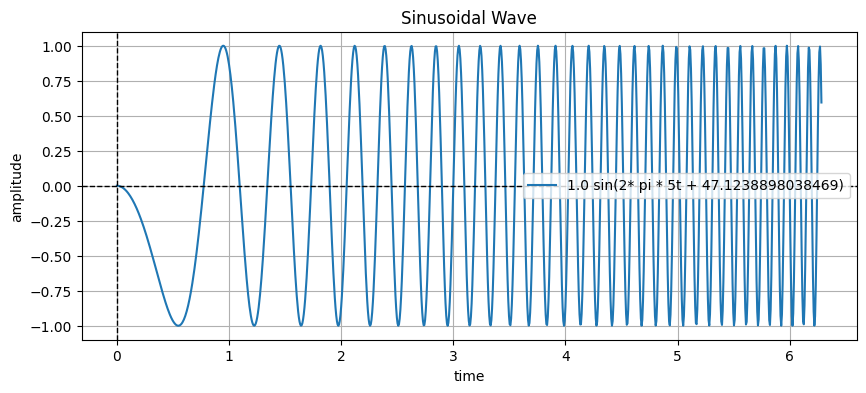

In [10]:
amplitude = 1.0
frequency = 5
pulse_width = 6.0
bandwidth = 10.0
sampling_frequency = 1000
axis_limit = 2
plot_chirp_sinusoid(amplitude,
                    frequency, 
                    pulse_width,
                    bandwidth, 
                    sampling_frequency, 
                    axis_limit)

In [11]:
def generate_chirp(amplitude=1.0, frequency=1.0, pulse_width=1.0, bandwidth=1.0, sampling_frequency=10000, axis_limit=2):
    t = np.linspace(0, axis_limit * np.pi, sampling_frequency)
    gamma = bandwidth / pulse_width
    quadratic_phase = np.pi * gamma * (t - pulse_width/2)**2
    y = amplitude * np.sin(2 * np.pi * frequency * t + quadratic_phase)
    return t, y

def simulate_received_signal(chirp_signal, delay_samples, attenuation=1.0):
    padded = np.concatenate([np.zeros(delay_samples), attenuation * chirp_signal])
    return padded[:len(chirp_signal)]  # Truncate to original length

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Chirp generation
t, tx_signal = generate_chirp(amplitude=1.0, frequency=5, pulse_width=1, bandwidth=100, sampling_frequency=2000, axis_limit=2)
print(t)
print(tx_signal)


# # 3. Generate received signal
# rx_signal = simulate_received_signal(tx_signal, delay_samples, attenuation=0.8)

# # 4. Plot both signals
# plt.figure(figsize=(12, 4))
# plt.plot(t, tx_signal, label='Transmitted Signal')
# plt.plot(t, rx_signal, label='Received Signal', linestyle='--')
# plt.title('Chirp Transmission and Echo')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()


[0.00000000e+00 3.14316424e-03 6.28632847e-03 ... 6.27689898e+00
 6.28004214e+00 6.28318531e+00]
[-4.91096681e-16  7.74297998e-01  9.81201162e-01 ...  7.89940363e-02
 -8.28598196e-01 -8.98141970e-01]


## Azimuth Resolution
Take a satellite platform moving at a velocity, $v$. We have that the change in time $\Delta \tau$ depends on the $PRI$. Hence, the distance covered by the platform between pulses is $\Delta \tau \cdot v$.

The difference in pulse length to the same target would hence be $2 \Delta \tau \cdot v \cdot \sin(\theta)$ where $\theta$ is the angle between the normal line to the target and the pulse direction. 

To calculate the phase difference of the two pulse waves, we can multiply the difference in distance by $\frac{2\pi}{\lambda}$. Therefore, we have:
$$
\phi = 2 \Delta \tau \cdot v\sin(\theta) \times \frac{2\pi}{\lambda}
$$

### Angular Frequency
Angular frequency ($\omega$) is the change in phase with respect to time. It is also defined as:
$$
\omega = 2\pi f_d = -\frac{d\phi}{d\tau}
$$
where $f_d$ is the doppler frequency.

We thus have that the doppler frequency derived as:
$$
f_d = -\frac{d\phi}{d\tau} \cdot \frac{1}{2\pi}
$$

For the case of the phase difference of the two pulse waves caused by the movement of the satellite platform, we will first differentiate the phase difference with respect to time.
$$
\frac{d\phi}{d\tau} = 2 \cdot v\sin(\theta) \times \frac{2\pi}{\lambda} \\
f_d = -\frac{2v\sin{\theta}}{\lambda}
$$

We note that $\theta$ is a function of the integration angle such that $\theta$ is bounded by $[-\frac{T_{integration}}{2}, \frac{T_{integration}}{2}]$.

Let $N$ be the number of pulse samples sent, we thus have:
$$
f_{d,1} = -\frac{2v\sin{(0.5 \cdot \theta_{integration})}}{\lambda}\\
f_{d,N} = -\frac{2v\sin{(-0.5 \cdot \theta_{integration})}}{\lambda} = \frac{2v\sin{0.5 \cdot \theta_{integration}}}{\lambda}
$$

The bandwidth can thus be dervied as:
$$
Bandwidth = f_{d,N} - f_{d,1} = \frac{4v \sin{(0.5 \cdot \theta_{integration})}}{\lambda}
$$

Resolution of a chirp signal in time domain is the -3dB power threshold width. This relates to $\frac{1}{BW}$ time difference for a chirp signal which has rectangular wave in frequency domain. Hence, we can find the width at -3dB power, corresponding to the time resolution, to be $\frac{\lambda}{4v\sin{(0.5\cdot\theta_{Integration})}}$. The azimuth distance resolution is thus:
$$
d_{az} = v\cdot\tau_{azimuth_resolution} = \frac{\lambda}{4\sin{(0.5 \cdot \theta_{integration})}}
$$

The integration angle can thus be derived as:
$$
\theta_{integration} = \frac{K_a \cdot \lambda}{2 \cdot d_{az}}
$$
where $K_a$ is the broadening factor for the azimuth resolution which is 1.2.
where we estimate $\sin{(0.5 \cdot \theta_{integration})} \approx 0.5 \cdot \theta_{integration}$ by small angle approximation.

In [13]:
def calculate_integration_angle(K_a = 1.2, wavelength = 0.03, azimuth_resolution = 1.0):
    """
    Calculate the satellite integration angle based on the given parameters.
    
    Parameters:
    K_a (float): Broadening Factor of azimuth resoluion to compensate for window filtering, default is 1.2.
    wavelength (float): Wavelength of the signal in meters, default is 0.03.
    azimuth_resolution (float): Desired azimuth resolution in meters, default is 1.0.
    
    Returns:
    float: The calculated integration angle in radians.
    """
    integration_angle = (K_a * wavelength) / (2 * azimuth_resolution)
    return integration_angle

In [14]:
def simulate_time_result(light_speed: float = 3e8, 
                         azimuth_length: float = 100.0, 
                         range_width: float = 100.0, 
                         sensor_speed: float = 100.0, 
                         grazing_angle_deg: float = 40.0,
                         integration_angle_deg: float = 20.0,
                         sensor_height: float = 10000.0,
                         max_capturable_height: float = 0,
                         sampling_frequency: float = 2000,
                         target_x: float = 0,
                         target_y: float = 0,
                         target_z: float = 50):

    # Derived parameters
    integration_angle_rad = math.radians(integration_angle_deg)
    grazing_angle_rad = math.radians(grazing_angle_deg)

    h = sensor_height
    v = sensor_speed
    L = azimuth_length
    B = range_width
    C = light_speed
    max_h = max_capturable_height
    x_t, y_t, z_t = target_x, target_y, target_z
    PRI = 1 / sampling_frequency

    y_c = h / math.tan(grazing_angle_rad)   # Horizontal distance to the origin of target strip
    d_c = h / math.sin(grazing_angle_rad)   # Slant distance to the origin of target strip

    delta_min = - y_c * math.tan(0.5 * integration_angle_rad)       # Maximum negative distance deviation from APC 
    delta_max = y_c * math.tan(0.5 * integration_angle_rad)         # Maximum positive distance deviation from APC

    num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

    # Function to calculate distance deviation of current sensor based on sample index
    cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

    # Function to calculate slant distance of the target from the current sensor position
    cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   

    # Assume that the distance deviation of sensor when it emit and receive signal is neglible
    cal_time_pulse = lambda distance : 2 * (distance / C)

    # Get near and far range time (to gate)
    near_range_time = cal_time_pulse(
            math.sqrt((max(0, h - max_h))**2 + (y_c - B/2.0)**2)
        )
    far_range_time = cal_time_pulse(
            math.sqrt((math.sqrt((delta_max + L/2.0)**2 + (y_c + B/2.0)**2))**2 + h**2)
        )   

    time_result = []

    for i in range(math.floor(num_of_samples)):
        dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
        target_slant_distance = cal_target_slant_distance(dist_deviation)   
        time_pulse = cal_time_pulse(target_slant_distance)
        time_result.append(time_pulse)

    time_result = np.array(time_result)

    # Get Chirp
    # emitted_chirps, received_chirps = simulate_chirp_signal(num_of_samples, time_result, PRI)
    # plot_chirp_signal(emitted_chirps, received_chirps)

    plot_time_pulse(time_result, near_range_time, far_range_time)


def plot_time_pulse(time_result, near_range_time, far_range_time):
    # Plot of pulse time
    plt.figure(figsize=(10, 4))

    plt.plot(time_result * (10**6)) # Plot of distance to pulse index
    plt.ylabel("Time (microseconds)")
    plt.xlabel("Pulse Index")
    plt.axhline(near_range_time * (10**6), color='black', linestyle='--', linewidth=1)
    plt.axhline(far_range_time * (10**6), color='black', linestyle='--', linewidth=1)
    plt.title("Time Points of pulse signal")
    plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
    plt.show()


def generate_chirp(start_time=0,
                   amplitude=1.0,
                   frequency=1.0,
                   pulse_width=1.0,
                   bandwidth=1.0,
                   sampling_frequency=10000):
    num_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(start_time, start_time + pulse_width, num_samples, endpoint=False)
    gamma = bandwidth / pulse_width
    quadratic_phase = np.pi * gamma * (t - (start_time + pulse_width / 2))**2
    y = amplitude * np.sin(2 * np.pi * frequency * t + quadratic_phase)
    return t, y


def simulate_chirp_signal(num_of_samples, time_result, PRI):
    emitted_chirps = []
    received_chirps = []

    for i in range(math.floor(num_of_samples)):
        current_time = i * PRI     # Each multiple of PRI indicates a new emitted chirp signal
        
        # Simulate emitted signal
        t_emit, tx_signal_emit = generate_chirp(current_time,
                                        amplitude=1.0,
                                        frequency=5,
                                        pulse_width=6.0,
                                        bandwidth=10.0,
                                        sampling_frequency=1000)

        # Simulate received signal
        t_recv, tx_signal_recv = generate_chirp(current_time+time_result[i],
                                        amplitude=1.0,
                                        frequency=5,
                                        pulse_width=6.0,
                                        bandwidth=10.0,
                                        sampling_frequency=1000)

        emitted_chirps.append((t_emit, tx_signal_emit))
        received_chirps.append((t_recv, tx_signal_recv))

    return emitted_chirps, received_chirps


In [ ]:
sliders = {
    "azimuth_length": FloatSlider(min=10.0, max=1000.0, step=0.1, value=100.0),
    "range_width": FloatSlider(min=10.0, max=1000.0, step=0.1, value=100.0),
    "sensor_speed": FloatSlider(min=10.0, max=500, step=0.1, value=100.0),
    "grazing_angle_deg": FloatSlider(min=0.1, max=90, step=0.1, value=40.0),
    "integration_angle_deg": FloatSlider(min=0, max=180, step=0.1, value=20.0),
    "sensor_height": FloatSlider(min=100, max=1000000, step=0.1, value=10000.0),
    "max_capturable_height": FloatSlider(min=0, max=1000, step=0.1, value=0),
    "sampling_frequency": IntSlider(min=1, max=5000, step=1, value=2000)
}
sliders["target_x"] = FloatSlider(min=-sliders["azimuth_length"].value/2, 
                                  max=sliders["azimuth_length"].value/2, 
                                  step=0.1, 
                                  value=0.0)
sliders["target_y"] = FloatSlider(min=-sliders["range_width"].value/2, 
                                  max=sliders["range_width"].value/2, 
                                  step=0.1, 
                                  value=0.0)
sliders["target_z"] = FloatSlider(min=0, 
                                  max=sliders["max_capturable_height"].value, 
                                  step=0.1, 
                                  value=0.0)

def update_target_x_slider_range(change):
    sliders["target_x"].min = change['new']/2
    sliders["target_x"].max = change['new']/2
    if sliders["target_x"].value > sliders["target_x"].max:
        sliders["target_x"].value = sliders["target_x"].max
    if sliders["target_x"].value < sliders["target_x"].min:
        sliders["target_x"].value = sliders["target_x"].min

def update_target_y_slider_range(change):
    sliders["target_y"].min = change['new']/2
    sliders["target_y"].max = change['new']/2
    if sliders["target_y"].value > sliders["target_y"].max:
        sliders["target_y"].value = sliders["target_y"].max
    if sliders["target_y"].value < sliders["target_y"].min:
        sliders["target_y"].value = sliders["target_y"].min

def update_target_z_slider_range(change):
    sliders["target_z"].max = change['new']
    if sliders["target_z"].value > sliders["target_z"].max:
        sliders["target_z"].value = sliders["target_z"].max

sliders["azimuth_length"].observe(update_target_x_slider_range, names="value")
sliders["range_width"].observe(update_target_y_slider_range, names="value")
sliders["max_capturable_height"].observe(update_target_z_slider_range, names="value")


def plot_distance_interactive(
                         azimuth_length,
                         range_width,
                         sensor_speed,
                         grazing_angle_deg,
                         integration_angle_deg,
                         sensor_height,
                         max_capturable_height,
                         sampling_frequency,
                         target_x,
                         target_y,
                         target_z):
    simulate_time_result(3e8, azimuth_length, range_width,
                         sensor_speed, grazing_angle_deg, integration_angle_deg,
                         sensor_height, max_capturable_height, sampling_frequency,
                         target_x, target_y, target_z)


ui = interactive(plot_distance_interactive, **sliders)
display(ui)

interactive(children=(FloatSlider(value=100.0, description='azimuth_length', max=1000.0, min=10.0), FloatSlide…

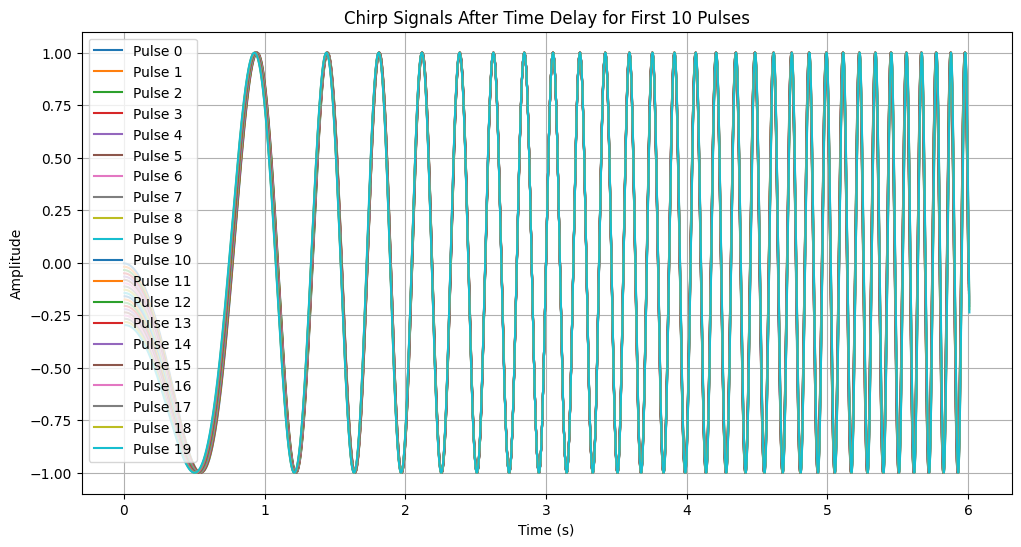

In [16]:
def generate_chirp(start_time=0,
                   amplitude=1.0,
                   frequency=5,
                   pulse_width=6.0,
                   bandwidth=10.0,
                   sampling_frequency=1000):
    num_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(start_time, start_time + pulse_width, num_samples, endpoint=False)
    gamma = bandwidth / pulse_width
    quadratic_phase = np.pi * gamma * (t - (start_time + pulse_width / 2))**2
    y = amplitude * np.sin(2 * np.pi * frequency * t + quadratic_phase)
    return t, y

# Using the stored time delays from the previous simulation
def simulate_chirps_and_plot(time_delays, PRI):
    plt.figure(figsize=(12, 6))
    for i, delay in enumerate(time_delays[:20]):  # Limit to first 10 for clarity
        start_time = i * PRI + delay
        t, y = generate_chirp(start_time=start_time)
        plt.plot(t, y, label=f'Pulse {i}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Chirp Signals After Time Delay for First 10 Pulses")
    plt.legend()
    plt.grid(True)

# Simulate delays as per prior structure
def compute_time_delays():
    light_speed = 3e8
    azimuth_length = 100.0
    range_width = 100.0
    sensor_speed = 100.0
    grazing_angle_deg = 40.0
    integration_angle_deg = 20.0
    sensor_height = 10000.0
    max_capturable_height = 0
    sampling_frequency = 2000
    target_x = 0
    target_y = 0
    target_z = 50

    integration_angle_rad = math.radians(integration_angle_deg)
    grazing_angle_rad = math.radians(grazing_angle_deg)

    h = sensor_height
    v = sensor_speed
    L = azimuth_length
    B = range_width
    C = light_speed
    max_h = max_capturable_height
    x_t, y_t, z_t = target_x, target_y, target_z
    PRI = 1 / sampling_frequency

    y_c = h / math.tan(grazing_angle_rad)
    delta_max = y_c * math.tan(0.5 * integration_angle_rad)

    num_of_samples = int((2 * abs(delta_max)) / (PRI * v))

    def cal_distance_deviation(idx): return (v * PRI) * int(idx) - delta_max
    def cal_target_slant_distance(dist_deviation): 
        return math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)
    def cal_time_pulse(distance): return 2 * (distance / C)

    time_result = []
    for i in range(num_of_samples):
        dist_deviation = cal_distance_deviation(i)
        target_slant_distance = cal_target_slant_distance(dist_deviation)
        time_pulse = cal_time_pulse(target_slant_distance)
        time_result.append(time_pulse)
    
    return time_result, PRI

# Run simulation and plot
time_delays, PRI = compute_time_delays()
simulate_chirps_and_plot(time_delays, PRI)


In [17]:
def generate_chirp(start_time=0,
                    pulse_width=1.0,
                    amplitude=1.0,
                    frequency=100_000.0,
                    bandwidth=1_000,
                    sampling_frequency=1_000_000):
    """
    Generate a chirp waveform starting from 0 to pulse_width (duration only), ignoring start_time offset.
    
    Returns the chirp waveform (1D array) only — timing managed at insertion level.
    """
    num_chirp_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(0, pulse_width, num_chirp_samples, endpoint=False)
    
    gamma = bandwidth / pulse_width
    phase = 2 * np.pi * frequency * t + np.pi * gamma * (t - pulse_width / 2) ** 2
    chirp = amplitude * np.sin(phase)
    
    return chirp



In [18]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def _generate_single_chirp(args):
    """
    Generates only the active chirp segment and its insertion index.
    """
    i, PRI, delay, pulse_width, bandwidth, frequency, sampling_frequency = args

    start_index = int(delay * sampling_frequency)
    chirp = generate_chirp(
        pulse_width=pulse_width,
        amplitude=1.0,
        frequency=frequency,
        bandwidth=bandwidth,
        sampling_frequency=sampling_frequency
    )

    if i % 10 == 0:
        print(f"i = {i}, start_index = {start_index}, chirp_length = {len(chirp)}, delay = {delay:.6f}s")

    return (i, start_index, chirp)



def simulate_sar_raw_data_threaded(num_of_samples, time_result, PRI,
                                   pulse_width=1.0, bandwidth=1_000.0, frequency=100_000.0,
                                   sampling_frequency=1_000_000):
    """
    Efficient SAR raw data simulator using only the windowed active chirp region.
    """

    # Determine how long the full signal buffer should be based on max delay + pulse width
    max_delay = max(time_result)
    total_duration = max_delay + pulse_width + pulse_width # Add extra pulse width to see end
    num_time_samples = int(np.ceil(total_duration * sampling_frequency))
    print(f"[INFO] Total fast-time samples allocated per row: {num_time_samples}")

    # Allocate zeroed raw data array
    raw_data = np.zeros((num_of_samples, num_time_samples), dtype=np.float32)

    # Package arguments
    args_list = [
        (i, PRI, time_result[i], pulse_width, bandwidth, frequency, sampling_frequency)
        for i in range(int(num_of_samples))
    ]

    # Threaded chirp generation
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(_generate_single_chirp, args_list))

    # Insert chirps at the right start index
    for i, start_index, chirp in results:
        end_index = start_index + len(chirp)
        if end_index <= raw_data.shape[1]:
            raw_data[i, start_index:end_index] = chirp
        else:
            # Trim if chirp would overflow the buffer
            valid_len = raw_data.shape[1] - start_index
            if valid_len > 0:
                raw_data[i, start_index:] = chirp[:valid_len]

    return raw_data


In [19]:
def plot_raw_sar_data(raw_data, sampling_frequency, time_result=None,
                      xlim_microseconds=None, downsample_fast=10, downsample_slow=1, show_delay=True):
    """
    Efficient visualisation of raw SAR data with downsampling.
    
    Parameters:
    - raw_data: 2D array (num_pulses, num_samples)
    - sampling_frequency: Hz
    - time_result: optional list of time delays (seconds)
    - xlim_microseconds: tuple (xmin, xmax) to limit x-axis
    - downsample_fast: downsample factor along fast time
    - downsample_slow: downsample factor along pulse index
    - show_delay: whether to plot slant range time delays
    """

    # Downsample both fast and slow time
    raw_data_ds = raw_data[::downsample_slow, ::downsample_fast].astype(np.float32)
    ds_fs = sampling_frequency / downsample_fast

    num_pulses, num_samples = raw_data_ds.shape
    fast_time_us = np.linspace(0, num_samples / ds_fs * 1e6, num_samples)
    pulse_indices = np.arange(0, raw_data.shape[0], downsample_slow)

    print(f"[INFO] Plotting {num_pulses} pulses, {num_samples} samples per pulse (downsampled)")
    print(f"[INFO] Fast time: {fast_time_us[0]:.2f}–{fast_time_us[-1]:.2f} μs")

    # Heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(raw_data_ds, aspect='auto',
               extent=[fast_time_us[0], fast_time_us[-1], pulse_indices[-1], pulse_indices[0]],
               cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Amplitude")
    plt.xlabel("Fast Time (μs)")
    plt.ylabel("Pulse Index (Slow Time)")
    plt.title("Simulated Raw SAR Data")

    if xlim_microseconds:
        plt.xlim(xlim_microseconds)

    plt.tight_layout()
    plt.show()

    # Optional: Slant Range Delay Plot
    if show_delay and time_result is not None:
        plt.figure(figsize=(8, 3))
        time_us = np.array(time_result) * 1e6
        plt.plot(np.arange(len(time_us)), time_us, linewidth=1)
        plt.xlabel("Pulse Index")
        plt.ylabel("Time Delay (μs)")
        plt.title("Slant Range Time Delays")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def simulate_time_result(light_speed: float = 3e8, 
                         azimuth_length: float = 100.0, 
                         range_width: float = 100.0, 
                         sensor_speed: float = 100.0, 
                         grazing_angle_deg: float = 40.0,
                         integration_angle_rad: float = 20.0,
                         sensor_height: float = 10000.0,
                         max_capturable_height: float = 0,
                         sampling_frequency: float = 2000,
                         PRF: float = 100,
                         target_x: float = 0,
                         target_y: float = 0,
                         target_z: float = 0):

    # Derived parameters
    grazing_angle_rad = math.radians(grazing_angle_deg)

    h = sensor_height
    v = sensor_speed
    L = azimuth_length
    B = range_width
    C = light_speed
    max_h = max_capturable_height
    x_t, y_t, z_t = target_x, target_y, target_z
    PRI = 1 / PRF

    y_c = h / math.tan(grazing_angle_rad)   # Horizontal distance to the origin of target strip

    delta_max = y_c * math.tan(0.5 * integration_angle_rad)         # Maximum positive distance deviation from APC

    num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

    # Function to calculate distance deviation of current sensor based on sample index
    cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

    # Function to calculate slant distance of the target from the current sensor position
    # cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   
    cal_target_slant_distance = lambda dist_deviation: math.sqrt(
        (h - z_t)**2 +
        (dist_deviation - x_t)**2 +
        (y_c - y_t)**2
    )   

    # Assume that the distance deviation of sensor when it emit and receive signal is neglible
    cal_time_pulse = lambda distance : (2 *distance) / C

    time_result = []

    for i in range(math.floor(num_of_samples)):
        dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
        target_slant_distance = cal_target_slant_distance(dist_deviation)   
        time_pulse = cal_time_pulse(target_slant_distance)
        time_result.append(time_pulse)
        if i in [0, math.floor(num_of_samples) // 2]:
            print(f"Sample {i}: Distance Deviation = {dist_deviation:.5f} m, Slant Distance = {target_slant_distance:.2f} m, Time Pulse = {time_pulse:.6f} s, delta_max = {delta_max:.2f} m")

    time_result = np.array(time_result)
    print(time_result[:10]*1e6)

    return time_result

Integration angle: 0.0360 degrees
Sample 0: Distance Deviation = -2145.38817 m, Slant Distance = 140020.96 m, Time Pulse = 0.000933 s, delta_max = 2145.39 m
Sample 286: Distance Deviation = -0.38817 m, Slant Distance = 139620.98 m, Time Pulse = 0.000931 s, delta_max = 2145.39 m
[933.47309408 933.46340204 933.45371257 933.44402569 933.43434138
 933.42465965 933.4149805  933.40530392 933.39562992 933.38595851]
Time taken to simulate time result: 0.51 milliseconds
Min delay: 928.36080 μs
Max delay: 933.47309 μs
Total shift: 5.11 μs
[INFO] Total fast-time samples allocated per row: 943474
i = 0, start_index = 933473, chirp_length = 5000, delay = 0.000933s
i = 10, start_index = 933376, chirp_length = 5000, delay = 0.000933s
i = 20, start_index = 933279, chirp_length = 5000, delay = 0.000933s
i = 30, start_index = 933183, chirp_length = 5000, delay = 0.000933s
i = 50, start_index = 932991, chirp_length = 5000, delay = 0.000933s
i = 60, start_index = 932896, chirp_length = 5000, delay = 0.000

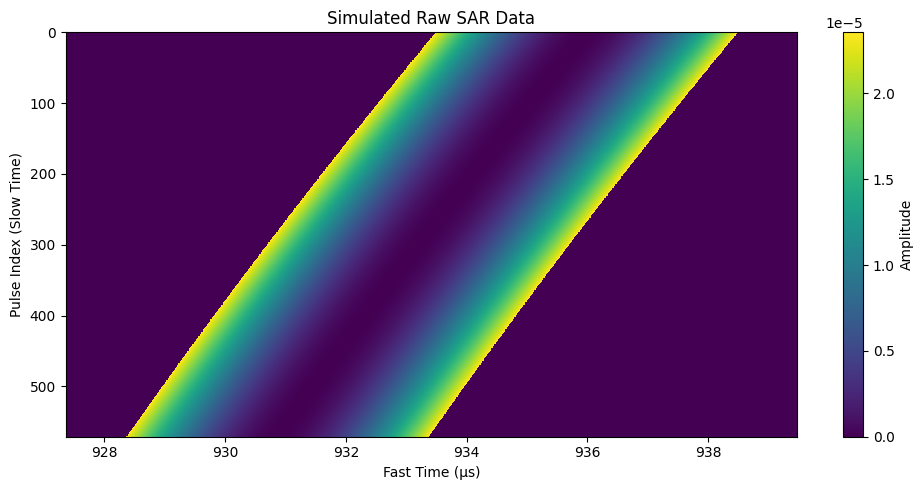

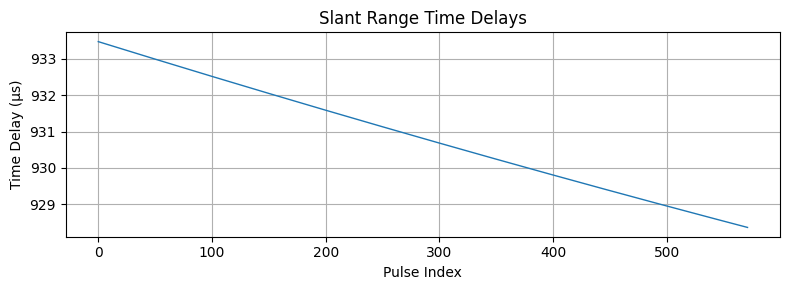

Time taken to plot raw SAR data: 2826.13 milliseconds


In [20]:
import time

radar_bands = {
    "L-band": {
        "frequency_range_GHz": (1.0, 2.0),
        "wavelength_cm": 3e10 / (1.5 * 1e9),  # ≈ 20.0 cm
        "application": "Air traffic control, ALOS-2 SAR"
    },
    "S-band": {
        "frequency_range_GHz": (2.0, 4.0),
        "wavelength_cm": 3e10 / (3.0 * 1e9),  # ≈ 10.0 cm
        "application": "Weather radar, marine radar"
    },
    "C-band": {
        "frequency_range_GHz": (4.0, 8.0),
        "wavelength_cm": 3e10 / (6.0 * 1e9),  # ≈ 5.0 cm
        "application": "Sentinel-1 SAR, meteorology"
    },
    "X-band": {
        "frequency_range_GHz": (8.0, 12.0),
        "wavelength_cm": 3e10 / (10.0 * 1e9),  # ≈ 3.0 cm
        "application": "High-res SAR (e.g., TerraSAR-X)"
    }
}

# Requested resolution
azimuth_resolution = 0.5
sampling_frequency = 1_000_000_000  # Hz
PRF = 1000  # Pulse Repetition Frequency in Hz
wavelength = radar_bands["X-band"]["wavelength_cm"] * 0.01  # Convert cm to m

integration_angle = calculate_integration_angle(K_a=1.2, wavelength=wavelength, azimuth_resolution=azimuth_resolution)
print(f"Integration angle: {integration_angle:.4f} degrees")

start_time = time.time_ns() * 10**-6  # Convert to milliseconds
time_result = simulate_time_result(
    integration_angle_rad=integration_angle,
    grazing_angle_deg=40.0,
    sensor_speed=7500.0,
    azimuth_length=50_000.0,
    range_width=50_000.0,
    sensor_height=100_000.0,
    PRF=PRF,
    max_capturable_height=0,
    sampling_frequency=sampling_frequency,
    target_x=25_000.0,
    target_y=25_000.0,
    target_z=0.0
)
time_result_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to simulate time result: {time_result_time - start_time:.2f} milliseconds")
delays_us = np.array(time_result) * 1e6
print(f"Min delay: {delays_us.min():.5f} μs")
print(f"Max delay: {delays_us.max():.5f} μs")
print(f"Total shift: {(delays_us.max() - delays_us.min()):.2f} μs")


raw_data = simulate_sar_raw_data_threaded(
    num_of_samples=len(time_result),
    time_result=time_result,
    PRI=1/PRF,
    pulse_width=0.000005,
    bandwidth=6.0,
    frequency=3e8/wavelength,
    sampling_frequency=sampling_frequency
)

raw_data_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to simulate raw SAR data: {raw_data_time - time_result_time:.2f} milliseconds")

# Find non-zero energy indices for xlim suggestion
energy = np.abs(raw_data).max(axis=0)
nonzero_indices = np.where(energy > 0.0)[0]

if len(nonzero_indices) > 0:
    start_us = nonzero_indices[0] / sampling_frequency * 1e6
    end_us = nonzero_indices[-1] / sampling_frequency * 1e6
    print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    plot_raw_sar_data(
        raw_data, 
        sampling_frequency, 
        time_result, 
        xlim_microseconds=(start_us-1, end_us+1), 
        downsample_fast=10,
        downsample_slow=1
        )
else:
    print("No significant signal detected.")

plotting_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to plot raw SAR data: {plotting_time - raw_data_time:.2f} milliseconds")

